In [1]:
import pandas as pd
import seaborn as sns
import rf
import os
import pygmt
import numpy as np

In [2]:
shubhdf = pd.read_csv(
    "/g/data/ha3/am3591/agrawal.txt",
    sep="\s+",
    names=("Network", "Station", "Latitude", "Longitude", "nRF", "TPsb", "Estimated Depth"),
    skiprows=2
)
shubhdf.index = shubhdf["Station"]
shubhdf.drop(labels=["Station", "nRF", "Estimated Depth"], axis=1, inplace=True)

In [3]:
all_analysis_dir = "/g/data/ha3/am3591/ALL-analysis"
latest_run = max(
    [
        os.path.join(all_analysis_dir, d)
        for d in os.listdir(all_analysis_dir)
        if os.path.isdir(os.path.join(all_analysis_dir, d))
    ],
    key=os.path.getmtime,
)
delaysdf = pd.read_csv(
    os.path.join(latest_run, "delays.txt"),
    sep="\s+",
    names=("Network", "Station", "Longitude", "Latitude", "TPsb"),
)
delaysdf.index = delaysdf["Station"]
delaysdf.drop("Station", axis=1, inplace=True)

In [4]:
df = delaysdf.join(shubhdf, how="outer", lsuffix=None, rsuffix="_shubh")
df.Network.fillna(df.Network_shubh, inplace=True)
df.Longitude.fillna(df.Longitude_shubh, inplace=True)
df.Latitude.fillna(df.Latitude_shubh, inplace=True)
df.drop(labels=["Network_shubh", "Latitude_shubh", "Longitude_shubh"], axis=1, inplace=True)
df.rename(columns={"TPsb": "TPsb_me"}, inplace=True)

In [41]:
df["TPsb_diff"] = (df["TPsb_me"] - df["TPsb_shubh"]).abs()
df.head()

,Network,Longitude,Latitude,TPsb_me,TPsb_shubh,TPsb_diff
Station,,,,,,
A4,AQ,140.999200,-21.663800,0.101,NaN,NaN
A7,AQ,142.434100,-21.345800,0.560,NaN,NaN
A8,AQ,143.165527,-21.649466,0.680,NaN,NaN
AEB01,5G,136.803000,-28.762500,NaN,0.59,NaN
AEB02,5G,135.324800,-25.987700,NaN,1.13,NaN


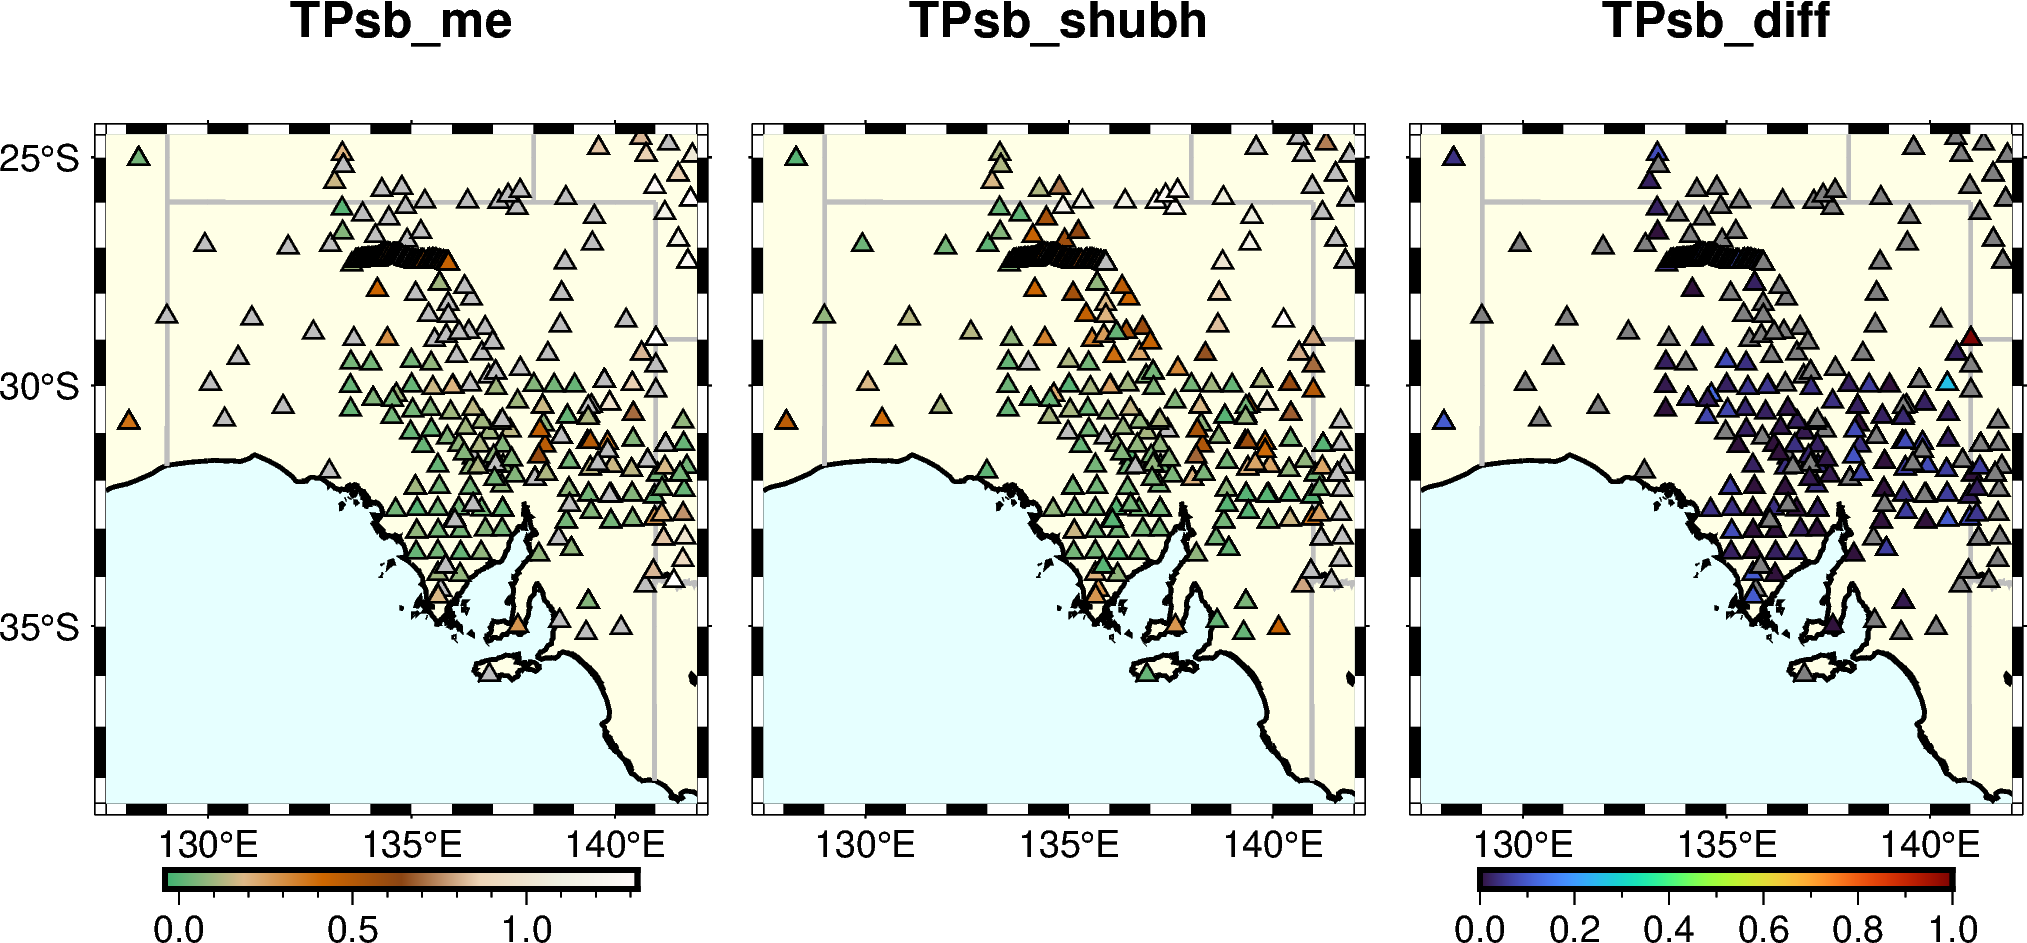

In [44]:
fig = pygmt.Figure()
pygmt.config(FONT_TITLE="12")
lons = df["Longitude"]
lats = df["Latitude"]
ln_min, ln_max = (127.5, 142)
lt_min, lt_max = (-38.5, -24.5)
region = [ln_min, ln_max, lt_min, lt_max]
_width = 5
projection = f"M12/11/{_width}c"
cbar_position = "JBC"

with fig.subplot(
    nrows=1, ncols=3, subsize=(f"{_width}c", "6c"), sharey="l", frame="WSne",
):
    for j, d in enumerate(["TPsb_me", "TPsb_shubh", "TPsb_diff"]):
        with fig.set_panel(panel=j):
            frame = f"+t{d}"
            fig.basemap(region=region, frame=frame, projection=projection)
            fig.coast(
                shorelines=1,
                land="#ffffe6",
                water="#e6ffff",
                borders="2/1p,grey",
                projection=projection,
                region=region,
            )
            if d in ["TPsb_me", "TPsb_shubh"]:
                _mn = (df[["TPsb_me", "TPsb_shubh"]].min()).min()
                _mx = (df[["TPsb_me", "TPsb_shubh"]].max()).min()
            else:
                _mn = df["TPsb_diff"].min()
                _mx = df["TPsb_diff"].max()
            pygmt.makecpt(cmap="turbo" if d == "TPsb_diff" else "dem3", series=[_mn, _mx])
            fig.plot(
                x=lons,
                y=lats,
                projection=projection,
                region=region,
                style=f"tc",
                pen="0.5p",
                fill=df[d],
                cmap=True,
                size=np.full_like(lons, 0.2),
            )
            if d in ["TPsb_me", "TPsb_diff"]:
                fig.colorbar(frame="af", position=f"{cbar_position}")
fig.show()


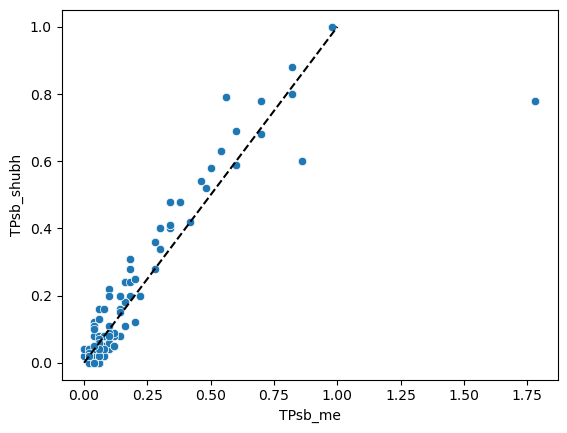

In [47]:
ax = sns.scatterplot(data=df, x="TPsb_me", y="TPsb_shubh")
ax.plot([0, 1], [0, 1], "k--")